# Import the package

In [1]:
from grmpy.test.auxiliary import refactor_results
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline  

import grmpy

/home/peisenha/.local/lib/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Simulation Process

In [2]:
df = grmpy.simulate('tutorial.grmpy.ini')

In [3]:
df.head()

,Y,D,1,2,3,Y1,Y0,U1,U0,UC,V
0,6.340961,1,1.0,-1.924565,-0.430810,6.340961,2.928770,0.670690,1.401037,-1.841197,-1.110850
1,-1.383042,0,1.0,-1.098141,0.402702,9.247288,-1.383042,5.483577,-1.516516,10.989881,3.989788
2,-1.148904,0,1.0,-1.746876,0.496243,8.211706,-1.148904,2.951362,-2.376859,8.365072,3.036850
3,4.894940,1,1.0,-1.808880,-1.620590,4.894940,0.884560,-0.508446,-0.448001,-0.345489,-0.285044
4,-2.329182,1,1.0,0.762787,-0.959615,-2.329182,-9.493056,-1.799731,-6.486958,1.381288,-3.305939


### The simulation process provides a the simulated data as a pickle file

In [4]:
pickle_file = pd.read_pickle('data.grmpy.pkl')
pickle_file.head()

,Y,D,1,2,3,Y1,Y0,U1,U0,UC,V
0,6.340961,1,1.0,-1.924565,-0.430810,6.340961,2.928770,0.670690,1.401037,-1.841197,-1.110850
1,-1.383042,0,1.0,-1.098141,0.402702,9.247288,-1.383042,5.483577,-1.516516,10.989881,3.989788
2,-1.148904,0,1.0,-1.746876,0.496243,8.211706,-1.148904,2.951362,-2.376859,8.365072,3.036850
3,4.894940,1,1.0,-1.808880,-1.620590,4.894940,0.884560,-0.508446,-0.448001,-0.345489,-0.285044
4,-2.329182,1,1.0,0.762787,-0.959615,-2.329182,-9.493056,-1.799731,-6.486958,1.381288,-3.305939


### Plot - Treatment effects and benefit distribution

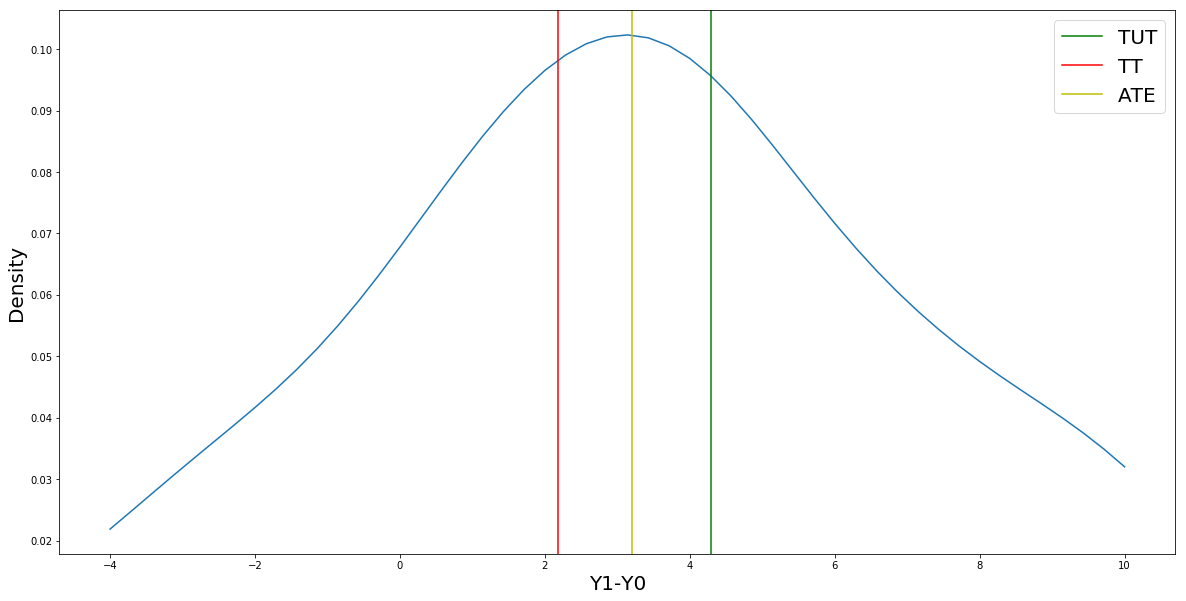

In [6]:
benefits= df.Y1 - df.Y0
TT = np.mean(benefits[df.D==1])
TUT = np.mean(benefits[df.D==0])
ATE = np.mean(benefits)
density = gaussian_kde(benefits)

xs = np.linspace(-4,10)
plt.figure(figsize=(20,10)) 

plt.plot(xs,density(xs))
plt.axvline(x=TUT, c='g', label='TUT')
plt.axvline(x=TT, c='r', label='TT')
plt.axvline(x=ATE, c='y',label='ATE')
plt.xlabel('Y1-Y0', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(fontsize=20)

plt.show()


In [7]:
df_ = grmpy.simulate('tutorial2.grmpy.ini')


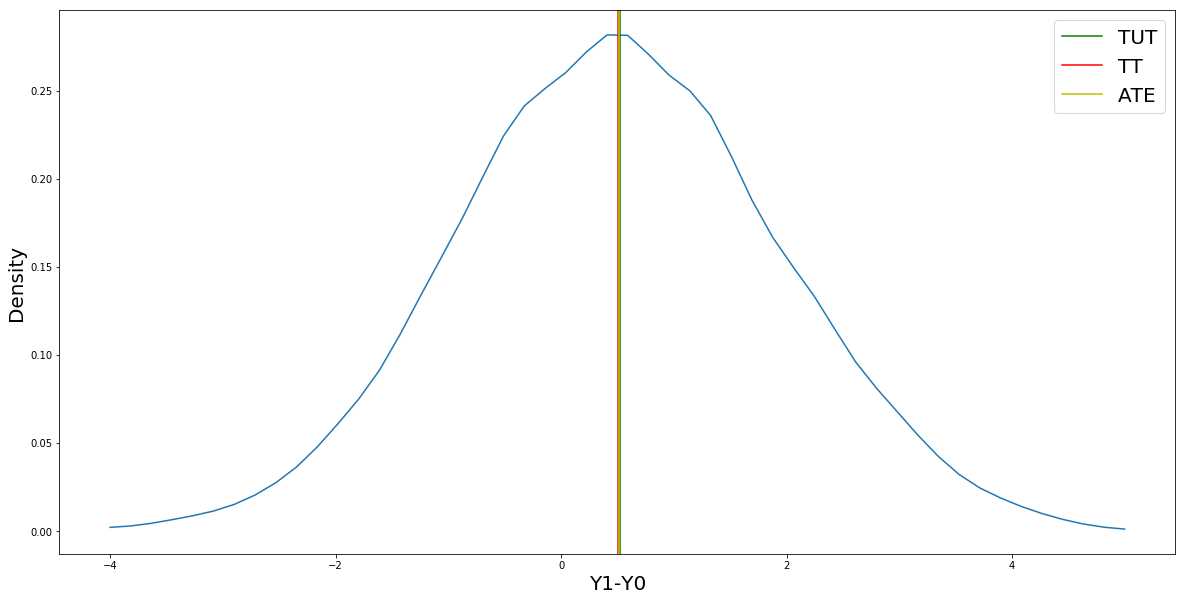

In [6]:
benefits_ = df_.Y1 - df_.Y0
TT = np.mean(benefits_[df_.D==1])
TUT = np.mean(benefits_[df_.D==0])
ATE = np.mean(benefits_)
density = gaussian_kde(benefits_)

xs = np.linspace(-4,5)
plt.figure(figsize=(20,10)) 

plt.plot(xs,density(xs))
plt.axvline(x=TUT, c='g', label='TUT')
plt.axvline(x=TT, c='r', label='TT')
plt.axvline(x=ATE, c='y',label='ATE')
plt.xlabel('Y1-Y0', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(fontsize=20)

plt.show()


In [8]:
"""This module contains a monte carlo example that illustrates the advantages of the grmpy
estimation strategy. Additionally the module creates four different figures for the reliability
section of the documentation.
"""
import warnings
import linecache
import shlex
import os

warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt
import statsmodels.api as sm
from os.path import join
from shutil import move
import numpy as np

from grmpy.test.random_init import print_dict
from grmpy.estimate.estimate import estimate
from grmpy.simulate.simulate import simulate
from grmpy.read.read import read



def update_correlation_structure(model_dict, rho):
    """This function takes a valid model specification and updates the correlation structure
    among the unobservables."""

    # We first extract the baseline information from the model dictionary.
    sd_v = model_dict['DIST']['all'][-1]
    sd_u = model_dict['DIST']['all'][0]

    # Now we construct the implied covariance, which is relevant for the initialization file.
    cov = rho * sd_v * sd_u
    model_dict['DIST']['all'][2] = cov

    # We print out the specification to an initialization file with the name mc_init.grmpy.ini.
    print_dict(model_dict)

def get_effect_grmpy(dict_):
    """This function simply reads the average treatment effect from the output file of the
    package."""
    name = dict_['SIMULATION']['source']
    linecache.clearcache()
    line = linecache.getline('{}.grmpy.info'.format(name), 25)
    print(line)
    stat = float(shlex.split(line)[1])
    return stat


def monte_carlo(file, grid_points):
    """This function estimates the ATE for a sample with different correlation structures between U1
     and V. Four different strategies for , OLS, 2SLS, LATE and perfect randomization are implemented.
     """
    # Define a dictionary with a key for each estimation strategy
    effects = {}
    for key_ in ['random', 'grmpy', '2sls', 'ols']:
        effects[key_] = []

    # Loop over different correlations between V and U_1
    for rho in np.linspace(0.00, 0.99, grid_points):

        # Readjust the initialization file values to add correlation
        model_spec = read(file)
        update_correlation_structure(model_spec, rho)

        # Simulate a Data set and specify exogeneous and endogeneous variables
        df_mc = simulate(file)

        endog, exog, instr = df_mc['Y'], df_mc[['1', 'D']], df_mc[['1', '2']]
        d_treated = df_mc['D'] == 1

        # Effect randomization
        stat = np.mean(endog.loc[d_treated]) - np.mean(endog.loc[~d_treated])
        effects['random'] += [stat]

        # Estimate  via grmpy
        rslt = estimate('test.grmpy.ini')
        stat = rslt['TREATED']['all'][0] - rslt['UNTREATED']['all'][0]
        effects['grmpy'] += [stat]

        # Estimate via 2SLS
        stat = IV2SLS(endog, exog, instr).fit().params[1]
        effects['2sls'] += [stat]

        # Estimate via OLS
        stat = sm.OLS(endog, exog).fit().params[1]
        effects['ols'] += [stat]

    return effects

def create_plots(effects, strategy, name, true):
    """The function creates the figures that illustrates the behavior of each estimator of the ATE
    when the correlation structure changes from 0 to 1."""

    # Determine the title for each strategy plot
    if strategy in ["grmpy", '2sls', 'ols']:
        title = name

    # Create a figure for each estimation strategy
        ax = plt.figure().add_subplot(111)

        grid = np.linspace(0.00, 0.99, len(effects[strategy]))
        true_ = np.tile(true, len(effects[strategy]))

        ax.set_xlim(0, 1)
        ax.set_ylim(0.4, 0.6)
        ax.set_ylabel(r"Effect")
        ax.set_xlabel(r"$\rho_{U_1, V}$")
        ax.plot(grid, effects[strategy], label="Estimate")

        ax.plot(grid, true_, label="True")

        ax.yaxis.get_major_ticks()[0].set_visible(False)
        plt.title(title)
        plt.legend()
        plt.show()

In [9]:
x = monte_carlo('test.grmpy.ini', 10)

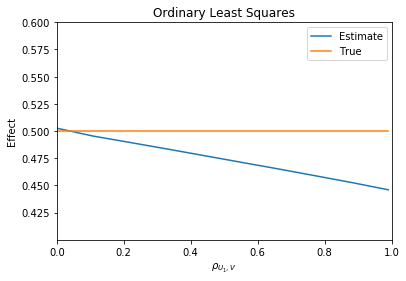

In [10]:
create_plots(x, 'ols', 'Ordinary Least Squares', 0.5)

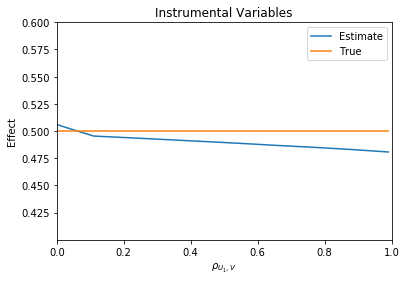

In [11]:
create_plots(x, '2sls', 'Instrumental Variables', 0.5)

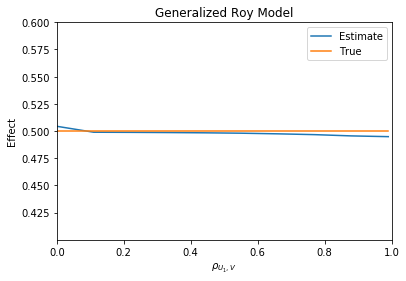

In [12]:
create_plots(x, 'grmpy', 'Generalized Roy Model', 0.5)